## Chocolate Bar Analysis

In [3]:
# Import Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration

In [4]:
# Import data and dispaly first rows
df = pd.read_csv('C:/Users/nickm/Desktop/Coding/Projects/chocolate-bar-analysis/Chocolate bar ratings 2022.csv')
df.head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
2,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
4,2542,5150,U.S.A.,2021,India,"Anamalai, batch 1",68%,"3- B,S,C","milk brownie, macadamia,chewy",3.50


In [5]:
# Display DataFrame summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   REF                               2588 non-null   int64  
 1   Company (Manufacturer)            2588 non-null   object 
 2   Company Location                  2588 non-null   object 
 3   Review Date                       2588 non-null   int64  
 4   Country of Bean Origin            2588 non-null   object 
 5   Specific Bean Origin or Bar Name  2588 non-null   object 
 6   Cocoa Percent                     2588 non-null   object 
 7   Ingredients                       2501 non-null   object 
 8   Most Memorable Characteristics    2588 non-null   object 
 9   Rating                            2588 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 202.3+ KB


In [6]:
# Print descriptive statistics of numerical columns
df.describe()

,REF,Review Date,Rating
count,2588.000000,2588.000000,2588.000000
mean,1459.185471,2014.545209,3.198319
std,773.852201,4.082722,0.444069
min,5.000000,2006.000000,1.000000
25%,820.000000,2012.000000,3.000000
50%,1470.000000,2015.000000,3.250000
75%,2122.000000,2018.000000,3.500000
max,2768.000000,2022.000000,4.000000


In [7]:
# Count unique values in each column
df.nunique()

REF                                  644
Company (Manufacturer)               593
Company Location                      65
Review Date                           17
Country of Bean Origin                63
Specific Bean Origin or Bar Name    1643
Cocoa Percent                         46
Ingredients                           21
Most Memorable Characteristics      2545
Rating                                12
dtype: int64

In [8]:
# Display number of NAs for each column
df.isna().sum()

REF                                  0
Company (Manufacturer)               0
Company Location                     0
Review Date                          0
Country of Bean Origin               0
Specific Bean Origin or Bar Name     0
Cocoa Percent                        0
Ingredients                         87
Most Memorable Characteristics       0
Rating                               0
dtype: int64

In [9]:
# Show rows with NAs in 'Ingredients'
df[df['Ingredients'].isna()].head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
88,1964,Amazing Cacao,Russia,2017,Peru,Maranon,70%,NaN,"raisins, pungent",3.00
89,1964,Amazing Cacao,Russia,2017,Peru,Platan Bajo,70%,NaN,"few grits, blackcherry, licorice",3.50
167,486,Artisan du Chocolat,U.K.,2010,Venezuela,Venezuela,100%,NaN,"very nutty, very bitter",1.75
303,81,Bonnat,France,2006,Blend,One Hundred,100%,NaN,"acidic, bitter, dry",1.50
330,341,Bouga Cacao (Tulicorp),Ecuador,2009,Ecuador,"El Oro, Hacienda de Oro",100%,NaN,"cardboard, very bitter, floral",1.50


In [10]:
# drop NA
df = df.dropna()

In [11]:
# show 5 most frequent values for each column
for col in df.columns:
    print(df[col].value_counts().head())

REF
414     10
24       9
431      8
1466     8
439      8
Name: count, dtype: int64
Company (Manufacturer)
Soma        57
Fresco      39
Arete       32
Bonnat      29
A. Morin    29
Name: count, dtype: int64
Company Location
U.S.A.    1150
Canada     175
France     171
U.K.       125
Italy       73
Name: count, dtype: int64
Review Date
2015    280
2014    243
2018    225
2016    213
2019    193
Name: count, dtype: int64
Country of Bean Origin
Venezuela             247
Peru                  235
Dominican Republic    228
Ecuador               205
Madagascar            178
Name: count, dtype: int64
Specific Bean Origin or Bar Name
Madagascar            53
Ecuador               39
Peru                  38
Dominican Republic    36
Chuao                 28
Name: count, dtype: int64
Cocoa Percent
70%    1038
75%     309
72%     301
80%      86
65%      85
Name: count, dtype: int64
Ingredients
3- B,S,C        1029
2- B,S           738
4- B,S,C,L       293
5- B,S,C,V,L     184
4- B,S,C,V      

# Recodes

### Rating - Categories

In [12]:
# From Author: "The ratings are between 1 and 5 with 1 considered the lowest rating and 5 as the highest rating possible."
    # 4.0 - 5.0 = Outstanding
    # 3.5 - 3.9 = Highly Recommended
    # 3.0 - 3.49 = Recommended
    # 2.0 - 2.9 = Disappointing
    # 1.0 - 1.9 = Unpleasant
print(df['Rating'].unique())

def rating_fun(rating):
    if rating >= 4:
        return 'Outstanding'
    elif rating >= 3.5:
        return 'Highly Recommended'
    elif rating >= 3:
        return 'Recommended'
    elif rating >= 2.0:
        return 'Disappointing'
    else:
        return 'Unpleasant'
    
df['Rating Categories'] = df['Rating'].apply(rating_fun)

print(df['Rating Categories'].value_counts())
print(pd.crosstab(df['Rating'], df['Rating Categories']))

[3.25 3.75 3.5  3.   2.75 4.   2.5  1.75 2.25 2.   1.5  1.  ]
Rating Categories
Recommended           980
Highly Recommended    872
Disappointing         528
Outstanding           114
Unpleasant              7
Name: count, dtype: int64
Rating Categories  Disappointing  Highly Recommended  Outstanding   
Rating                                                              
1.00                           0                   0            0  \
1.50                           0                   0            0   
1.75                           0                   0            0   
2.00                          29                   0            0   
2.25                          14                   0            0   
2.50                         159                   0            0   
2.75                         326                   0            0   
3.00                           0                   0            0   
3.25                           0                   0            0   
3.50 

### Cacoa Content - Categories

In [13]:
print(df['Cocoa Percent'].unique()[:5])
print(df['Cocoa Percent'].value_counts().head())

df['Cocoa Percent - Numerical'] = df['Cocoa Percent'].str[:-1].astype(float)
print(df['Cocoa Percent - Numerical'].describe())

def cococa_fun(cocoa_perc):
    if cocoa_perc >= 90:
        return '> 90%'
    elif cocoa_perc >= 80:
        return '80-89%'
    elif cocoa_perc >= 70:
        return '70-79%'
    elif cocoa_perc >= 60:
        return '60-69%'
    elif cocoa_perc >= 50:
        return '50-59%'
    else:
        return '< 50%'
    
df['Cocoa Percent - Categories'] = df['Cocoa Percent - Numerical'].apply(cococa_fun)

print(df['Cocoa Percent - Categories'].value_counts())

['76%' '68%' '72%' '80%' '70%']
Cocoa Percent
70%    1038
75%     309
72%     301
80%      86
65%      85
Name: count, dtype: int64
count    2501.000000
mean       71.472411
std         5.122815
min        42.000000
25%        70.000000
50%        70.000000
75%        74.000000
max       100.000000
Name: Cocoa Percent - Numerical, dtype: float64
Cocoa Percent - Categories
70-79%    1937
60-69%     348
80-89%     167
50-59%      28
> 90%       19
< 50%        2
Name: count, dtype: int64


### Ingredients - Number and Type of

In [14]:
print(df['Ingredients'].value_counts().head())
# In total, 7 different ingredients occur: B, S, S*, C, V, L, Sa

# Split 'Ingredients' column at '-' into No. of and List of Ingredients
# e.g.: '6-B,S,C,V,L,Sa' -> ['6', 'B,S,C,V,L,Sa']
df['Number of Ingredients'] = df['Ingredients'].str.split('-').apply(pd.Series)[0]
df['List of Ingredients'] = df['Ingredients'].str.split('-').apply(pd.Series)[1].str.strip()

# Expand occuring ingredients into 6 columns in order of appearance
# e.g. 'B,S,V' -> ['B', 'S', 'V', None, None, None]
ls_ingredients = df['List of Ingredients'].str.split(',').apply(pd.Series)
for col_nr, col in enumerate(ls_ingredients):
    df[f'Ingredient #{col_nr+1}'] = ls_ingredients[col_nr]

# Create a column for each ingredient indicating whether it's present in the chocolate bar
# e.g. 'B,S,V' -> [True, True, False, False, False, True, False]
unique_ingredients = ['B', 'S', 'S*', 'C', 'V', 'L', 'Sa']

def ingr_fun(cols, ingr):
    if cols.notna().sum() == 0:
        return np.NAN
    else:
        return (cols == ingr).sum() > 0

for i in unique_ingredients:
    #df[f'Ingredient {i}'] = df.filter(like='Ingredient #').apply(lambda x: np.NAN if x.notna().sum() == 0 else (x == i).sum() > 0, axis=1)
    df[f'Ingredient {i}'] = df.filter(like='Ingredient #').apply(ingr_fun, ingr=i, axis=1)

print('\nIngredient Count:\n', df.loc[:,'Ingredient B':'Ingredient Sa'].astype('boolean').sum())


Ingredients
3- B,S,C        1029
2- B,S           738
4- B,S,C,L       293
5- B,S,C,V,L     184
4- B,S,C,V       141
Name: count, dtype: int64

Ingredient Count:
 Ingredient B     2501
Ingredient S     2417
Ingredient S*      77
Ingredient C     1706
Ingredient V      353
Ingredient L      500
Ingredient Sa      37
dtype: int32


### Most Memorable Characteristics - Number and Type of

In [15]:
#print(df['Most Memorable Characteristics'].value_counts().head())
# exemplary format: 'spicy, cocoa', 'sandy, sweet, cocoa'

# split characteristics into columns
characts = df['Most Memorable Characteristics'].str.split(',').apply(lambda x: [e.strip() for e in x]).apply(pd.Series)
for col_nr, col in enumerate(characts):
    df[f'Characteristic #{col_nr+1}'] = characts[col_nr]

# create a list with all mentioned characteristics
ls_characts = []
for col in range(len(characts.columns)):
    ls_characts.extend(characts.loc[characts[col].notna()][col].to_list())

all_charact_counts = pd.DataFrame(ls_characts).value_counts().rename_axis('charact').reset_index(name='counts')
#print(all_charact_counts[:20])
top_characts = all_charact_counts[:20]['charact'].tolist()

for i in top_characts:
    df[f'Characteristic - {i}'] = df['Most Memorable Characteristics'].apply(lambda x: i in x)

# Check results
print(all_charact_counts[:20].head())
print(df.filter(like='Characteristic - ').sum().head())

# Counts differ e.g. 'sweet': n=276 in all_charact_counts vs. n=324 in column 'Characteristic - sweet'
print(all_charact_counts[all_charact_counts['charact'].str.contains('sweet')].head())
# Reason: there are entries not solely containing the attribute 'sweet' but slightly more 
#  specific evaluation, e.g. 'very sweet', 'too sweet'
print('Number of unique characteristics containing the word "cocoa":',
      len(all_charact_counts[all_charact_counts['charact'].str.contains('cocoa')]))
# Looking at 'cocoa', there are 51 unique evaluations containing this word, e.g. 'rich cocoa', 
# 'sweet cocoa',... This way of computation should be fine, as e.g. 'sweet cocoa' can certainly 
# be associated with both 'sweet' and 'cocoa', while 'very sweet' is still 'sweet'.

  charact  counts
0   sweet     263
1   nutty     260
2   cocoa     251
3  roasty     218
4  creamy     191
Characteristic - sweet     310
Characteristic - nutty     275
Characteristic - cocoa     419
Characteristic - roasty    232
Characteristic - creamy    191
dtype: int64
          charact  counts
0           sweet     263
115    sweet edge      11
126    very sweet      10
155     too sweet       7
224  overly sweet       3
Number of unique characteristics containing the word "cocoa": 49


### Store new DF to .csv

In [27]:
# show variabls in df
df.columns

# drop temporary vars e.g. 'Ingredient #1'
df_out = df.drop(columns=list(df.filter(regex='#')))
df_out.columns

# store to csv
df_out.to_csv('Chocolate bar ratings 2022 - RECODE.csv', encoding='utf-8', index=False)


# Data Visualization: Variable Distribution and Rating Means

### Ratings and Sampling Activity

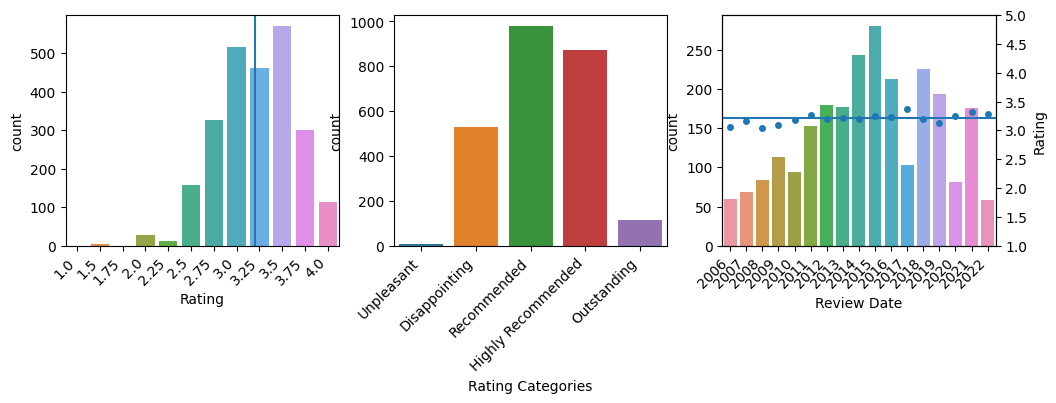

In [16]:
fig, axs = plt.subplots(figsize=(12, 3), ncols=3)

# Rating Numeric
sns.countplot(data=df, x='Rating', ax=axs[0])
# draw mean (~3.2, which is between x-point 7 (=3.0) and 8 (=3.25))
axs[0].axvline(7.8)

# Rating Categories
rating_cats = ['Unpleasant', 'Disappointing', 'Recommended', 'Highly Recommended', 'Outstanding']
sns.countplot(data=df, x='Rating Categories', ax=axs[1], order=rating_cats)

# Review Date
rd_mean = df.groupby('Review Date')['Rating'].mean().to_frame()
rd_mean['Count'] = df['Review Date'].value_counts()
# Rating Means as second axis
ax2_1 = axs[2].twinx()
sns.countplot(data=df, x='Review Date', ax=axs[2])
sns.stripplot(x=rd_mean.index, y=rd_mean['Rating'], ax=ax2_1)
ax2_1.set_ylim(1,5)
ax2_1.axhline(df['Rating'].mean());

for i in range(len(axs)):
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, horizontalalignment='right')


### Manufacturer and bean origin (top 20)

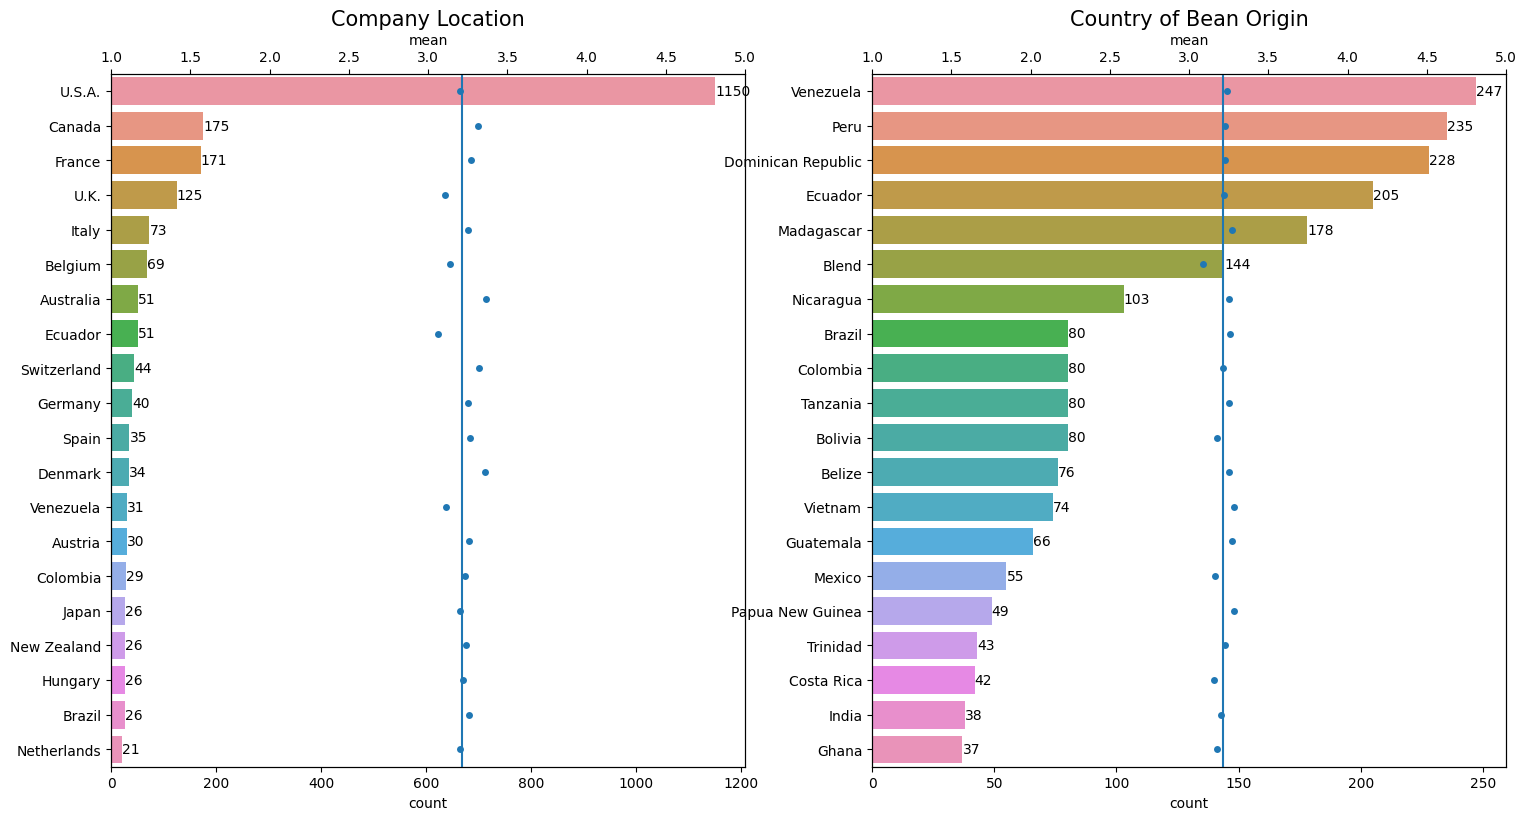

In [17]:
fig, axs = plt.subplots(figsize=(18, 9), ncols=2)

vars = ['Company Location', 'Country of Bean Origin']

for nr, var in enumerate(vars):
    # count country occurence and store top 20
    var_count = df[var].value_counts().head(20).to_frame()
    
    # get the aggregated mean for the top 20 countries
    var_means_ls = []
    for i in var_count.index:
        var_means_ls.append(df[df[var] == i]['Rating'].mean())
    var_count['mean'] = var_means_ls

    # Plot
    sns.barplot(x=var_count['count'], y=var_count.index, ax=axs[nr]).set_title(var, fontdict={'size': 15})
    axs2 = axs[nr].twiny()
    sns.stripplot(x=var_count['mean'], y=var_count.index, ax=axs2)
    axs2.set_xlim(1,5)
    axs2.axvline(df['Rating'].mean())
    axs[nr].bar_label(axs[nr].containers[0], labels=var_count['count'])
    axs[nr].set(ylabel=None)


### Cocoa Percent

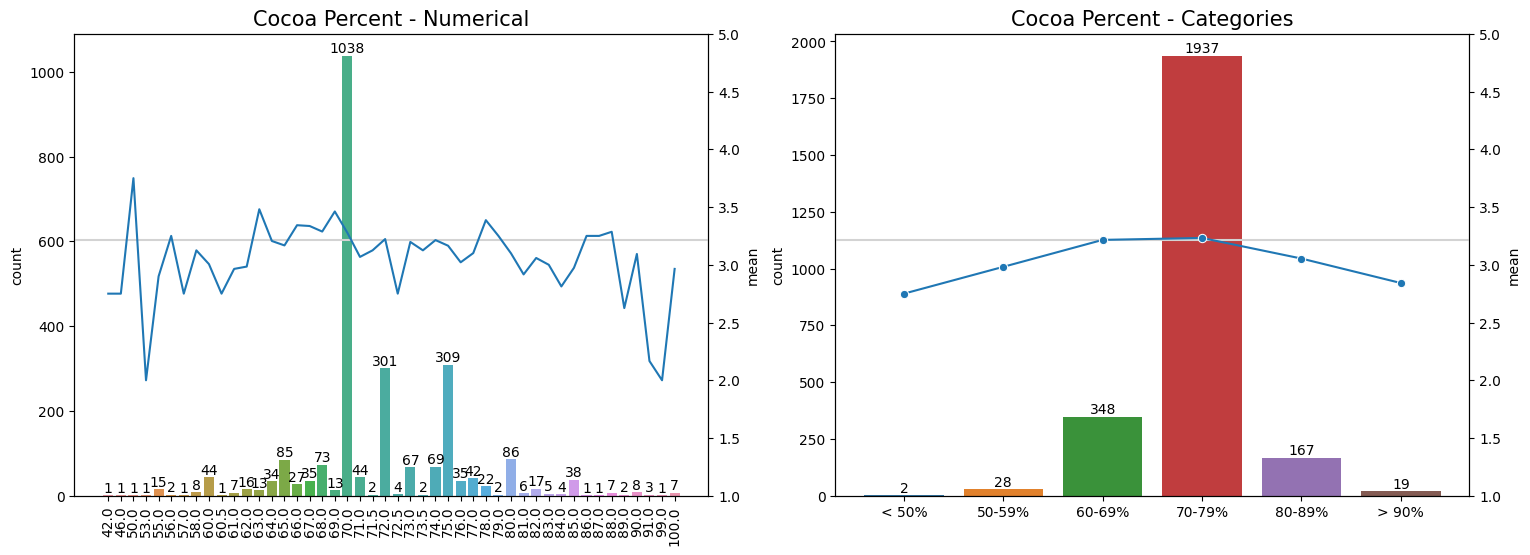

In [18]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=2)

# Cocoa Percent - Numerical
cpn_count = df['Cocoa Percent - Numerical'].value_counts().to_frame()
cpn_count['mean'] = df.groupby('Cocoa Percent - Numerical')['Rating'].mean()
cpn_count = cpn_count.sort_index()
cpn_count.index = cpn_count.index.map(str)
# Plot
sns.barplot(x=cpn_count.index, y=cpn_count['count'], ax=axs[0]).set_title('Cocoa Percent - Numerical', fontdict={'size': 15})
axs0_1 = axs[0].twinx()
axs0_1.axhline(df['Rating'].mean(), color='lightgrey')
axs0_1.set_ylim(1,5)
sns.lineplot(x=cpn_count.index, y=cpn_count['mean'], ax=axs0_1)
axs[0].bar_label(axs[0].containers[0], labels=cpn_count['count'])
axs[0].set(xlabel=None)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90);

# Cocoa Content - Categories
cpc_count = df['Cocoa Percent - Categories'].value_counts().to_frame()
cpc_count['mean'] = df.groupby('Cocoa Percent - Categories')['Rating'].mean()
cpc_order = ['< 50%', '50-59%', '60-69%', '70-79%', '80-89%', '> 90%']
cpc_count = cpc_count.sort_index(key=lambda x: x.map(lambda y: cpc_order.index(y)))
# Plot
sns.barplot(x=cpc_count.index, y=cpc_count['count'], order=cpc_order, ax=axs[1]).set_title('Cocoa Percent - Categories', fontdict={'size': 15})
axs1_1 = axs[1].twinx()
axs1_1.axhline(df['Rating'].mean(), color='lightgrey')
axs1_1.set_ylim(1,5)
sns.lineplot(x=cpc_count.index, y=cpc_count['mean'], marker='o', ax=axs1_1)
axs[1].bar_label(axs[1].containers[0], labels=cpc_count['count'])
axs[1].set(xlabel=None);

### Number of Ingredients

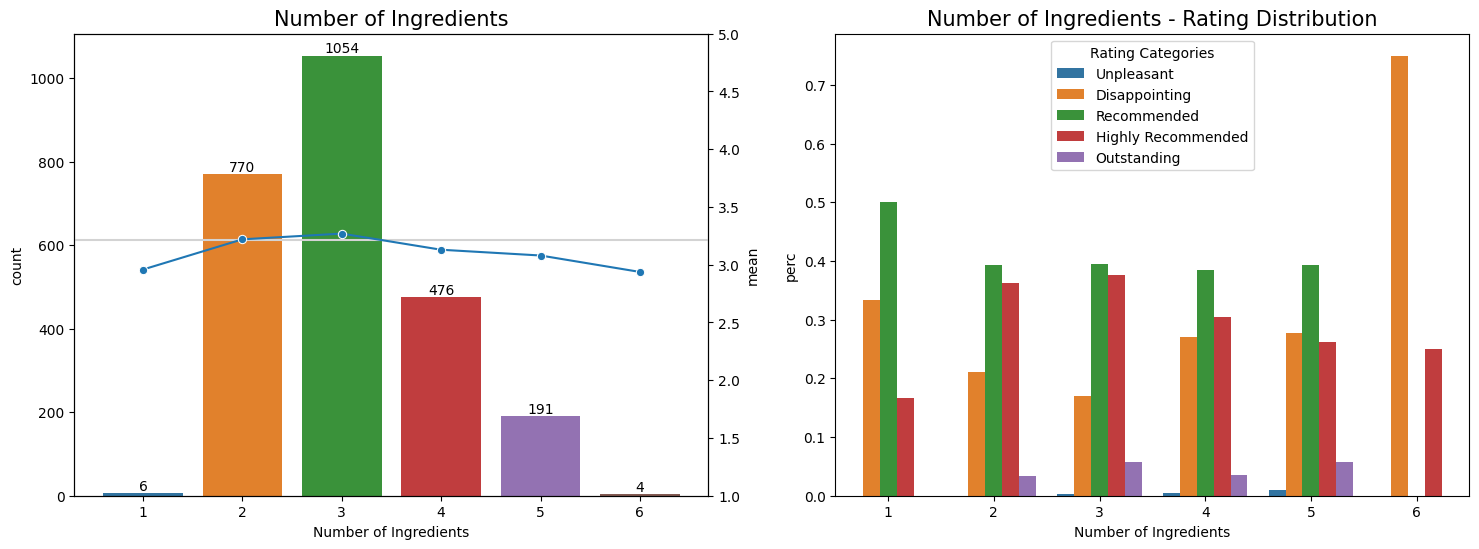

In [19]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=2)

# Number of Ingredients
ni_count = df['Number of Ingredients'].value_counts().to_frame()
ni_count['mean'] = df.groupby('Number of Ingredients')['Rating'].mean()
ni_count = ni_count.sort_index()
#print(ni_count)
# Plot
sns.barplot(x=ni_count.index, y=ni_count['count'], ax=axs[0]).set_title('Number of Ingredients', fontdict={'size': 15})
axs0_1 = axs[0].twinx()
axs0_1.axhline(df['Rating'].mean(), color='lightgrey')
axs0_1.set_ylim(1,5)
sns.lineplot(x=ni_count.index, y=ni_count['mean'], marker='o', ax=axs0_1)
axs[0].bar_label(axs[0].containers[0], labels=ni_count['count'])

# Number of Ingredients - Split by Rating Category
ni_rating = df.groupby(['Number of Ingredients', 'Rating Categories'])['Rating Categories'].value_counts().to_frame().reset_index()
ni_rating['gr_count'] = ni_rating.groupby('Number of Ingredients')['count'].transform('sum')
ni_rating['perc'] = ni_rating['count'] / ni_rating['gr_count']
#print(ni_rating.head())
# Plot
sns.barplot(x=ni_rating['Number of Ingredients'], y=ni_rating['perc'], hue=ni_rating['Rating Categories'], hue_order=rating_cats, ax=axs[1]).set_title('Number of Ingredients - Rating Distribution', fontdict={'size': 15});



### Type of Ingredients

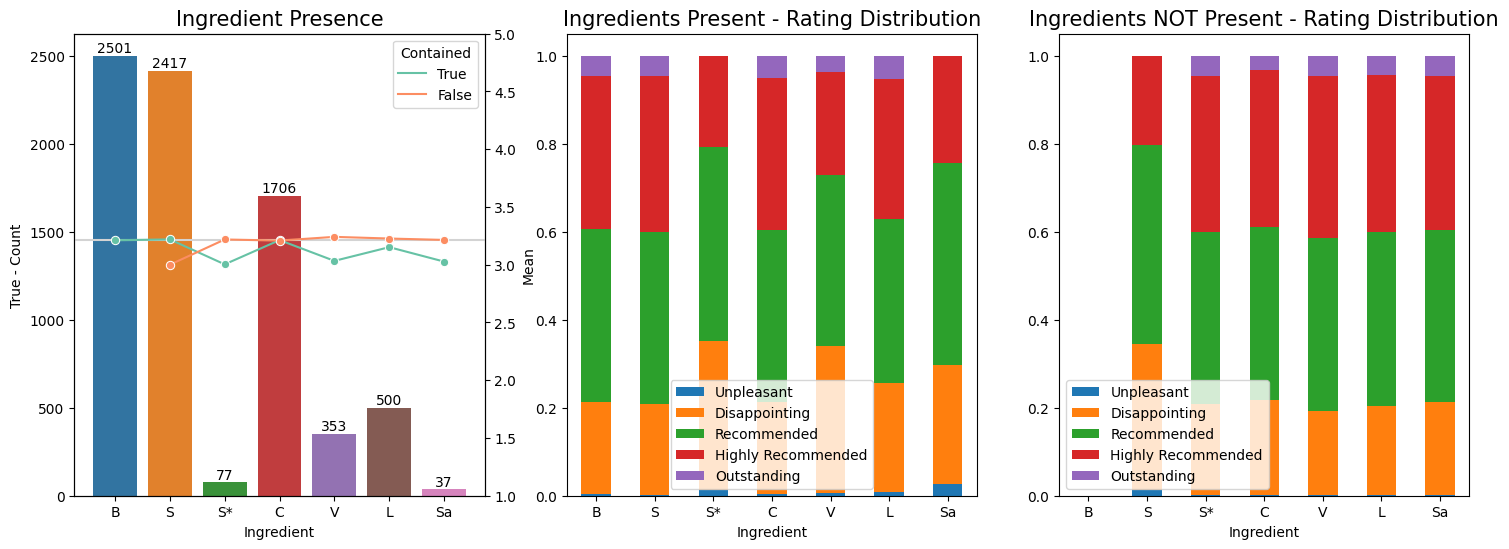

In [20]:
# Transform data to produce stacked barplots
ingr_ls = []
for ingr in unique_ingredients:
    ingr_cols = ['Ingredient']
    temp_ls = [ingr]
    for cont in [True, False]:
        temp_df = df[df[f'Ingredient {ingr}'] == cont]
        temp_ls.extend([len(temp_df), temp_df['Rating'].mean()])
        ingr_cols.extend([f'{cont} - Count', f'{cont} - Mean'])
        for rc in rating_cats:
            temp_ls.append(len(temp_df[temp_df['Rating Categories'] == rc]) / max(1, len(temp_df)))
            ingr_cols.append(f'{cont} - {rc} - Count')
    ingr_ls.append(temp_ls)

ingrs = pd.DataFrame(ingr_ls, columns=ingr_cols)

ingrs_means_only = (pd.concat([ingrs[['Ingredient', 'True - Mean']].rename(columns={'True - Mean' : 'Mean'}), 
                               ingrs[['Ingredient', 'False - Mean']].rename(columns={'False - Mean' : 'Mean'})],
                               ignore_index=True))
ingrs_means_only['Contained'] = [True for x in range(len(unique_ingredients))] + [False for x in range(len(unique_ingredients))]

ingrs_true_rc_only = ingrs.drop(columns=['True - Count', 'True - Mean', *list(ingrs.filter(regex='False'))])
ingrs_true_rc_only.columns = ['Ingredient', *rating_cats]

ingrs_false_rc_only = ingrs.drop(columns=['False - Count', 'False - Mean', *list(ingrs.filter(regex='True'))])
ingrs_false_rc_only.columns = ['Ingredient', *rating_cats]

# Plot
fig, axs = plt.subplots(figsize=(18, 6), ncols=3)

sns.barplot(x=ingrs['Ingredient'], y=ingrs['True - Count'], ax=axs[0]).set_title('Ingredient Presence', fontdict={'size': 15})
axs[0].bar_label(axs[0].containers[0], labels=ingrs['True - Count'])
axs0_1 = axs[0].twinx()
axs0_1.axhline(df['Rating'].mean(), color='lightgrey')
axs0_1.set_ylim(1,5)
sns.lineplot(x=ingrs_means_only['Ingredient'], y=ingrs_means_only['Mean'], hue=ingrs_means_only['Contained'], hue_order=[True, False], marker='o', palette = sns.color_palette("Set2", 2), ax=axs0_1)

ingrs_true_rc_only.set_index('Ingredient').plot(kind='bar', stacked=True, ax=axs[1]).set_title('Ingredients Present - Rating Distribution', fontdict={'size': 15})
ingrs_false_rc_only.set_index('Ingredient').plot(kind='bar', stacked=True, ax=axs[2]).set_title('Ingredients NOT Present - Rating Distribution', fontdict={'size': 15})

for i in range(len(axs)):
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0)


### Most Memorable Characteristics (mentioned or not)

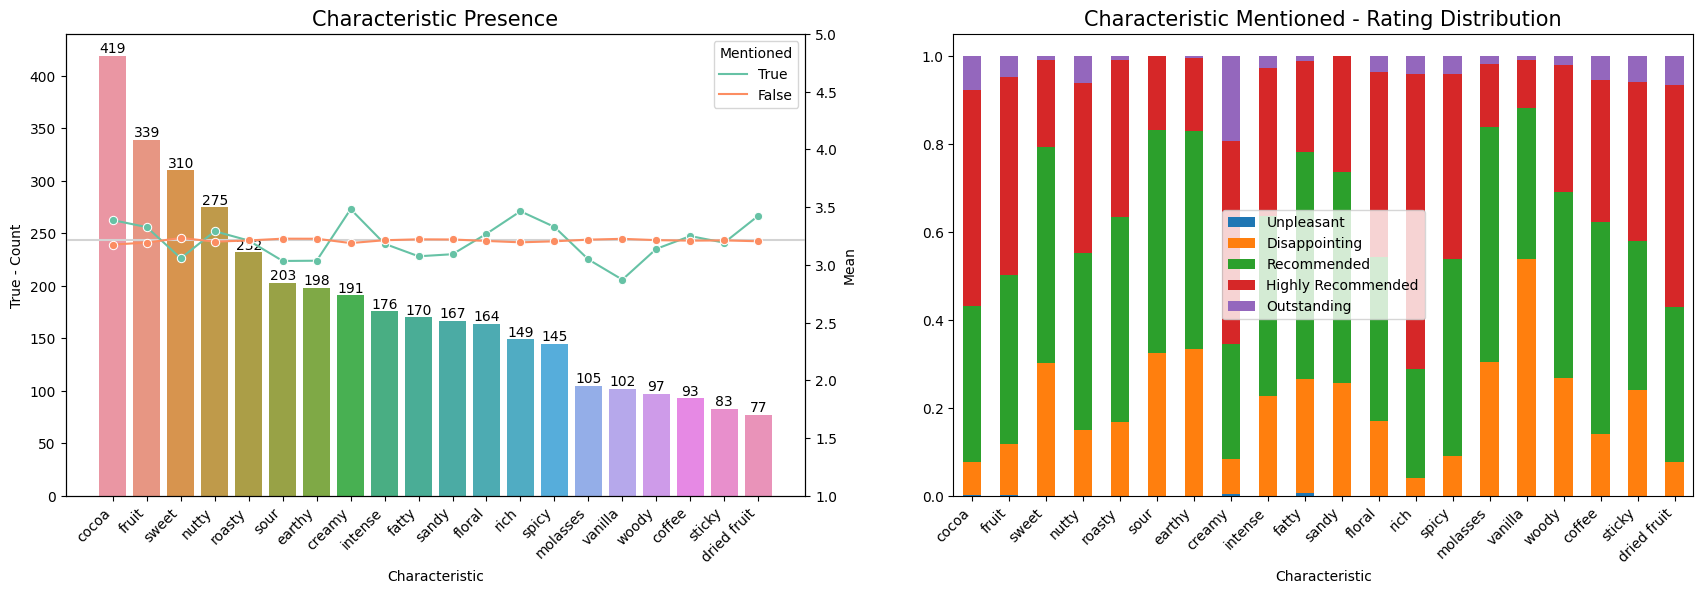

In [21]:
# Transform data to produce stacked barplots
chrc_ls = []
for chrc in top_characts:
    chrc_cols = ['Characteristic']
    temp_ls = [chrc]
    for cont in [True, False]:
        temp_df = df[df[f'Characteristic - {chrc}'] == cont]
        temp_ls.extend([len(temp_df), temp_df['Rating'].mean()])
        chrc_cols.extend([f'{cont} - Count', f'{cont} - Mean'])
        for rc in rating_cats:
            temp_ls.append(len(temp_df[temp_df['Rating Categories'] == rc]) / max(1, len(temp_df)))
            chrc_cols.append(f'{cont} - {rc} - Count')
    chrc_ls.append(temp_ls)

chrcs = pd.DataFrame(chrc_ls, columns=chrc_cols).sort_values(by='True - Count', ascending=False)

chrcs_means_only = (pd.concat([chrcs[['Characteristic', 'True - Mean']].rename(columns={'True - Mean' : 'Mean'}), 
                               chrcs[['Characteristic', 'False - Mean']].rename(columns={'False - Mean' : 'Mean'})],
                               ignore_index=True))
chrcs_means_only['Mentioned'] = [True for x in range(len(top_characts))] + [False for x in range(len(top_characts))]

chrcs_true_rc_only = chrcs.drop(columns=['True - Count', 'True - Mean', *list(chrcs.filter(regex='False'))])
chrcs_true_rc_only.columns = ['Characteristic', *rating_cats]

# Plot
fig, axs = plt.subplots(figsize=(21, 6), ncols=2)

sns.barplot(x=chrcs['Characteristic'], y=chrcs['True - Count'], ax=axs[0]).set_title('Characteristic Presence', fontdict={'size': 15})
axs[0].bar_label(axs[0].containers[0], labels=chrcs['True - Count'])
axs0_1 = axs[0].twinx()
axs0_1.axhline(df['Rating'].mean(), color='lightgrey')
axs0_1.set_ylim(1,5)
sns.lineplot(x=chrcs_means_only['Characteristic'], y=chrcs_means_only['Mean'], hue=chrcs_means_only['Mentioned'], hue_order=[True, False], palette = sns.color_palette("Set2", 2), marker='o', ax=axs0_1)

chrcs_true_rc_only.set_index('Characteristic').plot(kind='bar', stacked=True, ax=axs[1]).set_title('Characteristic Mentioned - Rating Distribution', fontdict={'size': 15})

for i in range(len(axs)):
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, horizontalalignment='right')